### Baseline Models

In [2]:
# necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer


### Preprocessing Pipeline

In [16]:
def preprocess_data(df, test_size=0.2, random_state=42):
    # Define target variables and feature variables
    X = df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP', 'WEATHER_DELAY', 'CANCELLED'])
    y = df['DEP_DELAY_GROUP'].replace({-2: 0, -1: 0})  # Replace -2 and -1 with 0
    
    # Define numerical and categorical columns
    categorical_cols = ['ORIGIN', 'DEST']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Train-test split (not random, but sequential)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    
    # Ensure encoder learns all categories, even those missing in training
    all_categories = {col: X[col].unique() for col in categorical_cols}
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
        ])
    
    # Preprocess the data (Fit on training data and transform both training and test data)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_torch = torch.FloatTensor(X_train_processed.toarray())
    Y_train_torch = torch.LongTensor(Y_train.values)
    X_test_torch = torch.FloatTensor(X_test_processed.toarray())
    Y_test_torch = torch.LongTensor(Y_test.values)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_torch = torch.tensor(scaler.fit_transform(X_train_torch), dtype=torch.float32)
    X_test_torch = torch.tensor(scaler.transform(X_test_torch), dtype=torch.float32)
    
    # Generate feature names after OneHotEncoding for categorical columns
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = numerical_cols + list(categorical_feature_names)
    
    return X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names

### Multinomial Logistic Regression Function

In [6]:
def train_multinomial_logistic_regression(X_train, Y_train, X_test, Y_test, num_epochs=100, lr=0.01):
    class MultinomialLogisticRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultinomialLogisticRegression, self).__init__()
            self.linear = nn.Linear(input_dim, output_dim)
        
        def forward(self, x):
            return self.linear(x)  # Softmax is included in CrossEntropyLoss

    # Model, loss, optimizer
    input_dim = X_train.shape[1]  # Number of features after preprocessing
    output_dim = len(torch.unique(Y_train))
    model = MultinomialLogisticRegression(input_dim, output_dim)

    criterion = nn.CrossEntropyLoss()  # Includes softmax
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Lists to store loss and accuracy for plotting
    train_loss_list = []
    train_accuracy_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this epoch
        with torch.no_grad():
            y_pred = torch.argmax(outputs, dim=1)
            correct = (y_pred == Y_train).float()
            accuracy = correct.mean()

        # Store loss and accuracy
        train_loss_list.append(loss.item())
        train_accuracy_list.append(accuracy.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

    # Evaluate metrics after training
    model.eval()  # Set model to evaluation mode

    # Get predictions for both training and test sets
    with torch.no_grad():
        y_pred_train = torch.argmax(model(X_train), dim=1)
        y_pred_test = torch.argmax(model(X_test), dim=1)

    # Convert predictions and labels to numpy arrays for metric calculations
    y_train_np = Y_train.cpu().numpy()
    y_test_np = Y_test.cpu().numpy()
    y_pred_train_np = y_pred_train.cpu().numpy()
    y_pred_test_np = y_pred_test.cpu().numpy()

    # Calculate accuracy, precision, recall, f1-score for training and test sets
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train_np, y_pred_train_np),
            'precision': precision_score(y_train_np, y_pred_train_np, average='weighted'),
            'recall': recall_score(y_train_np, y_pred_train_np, average='weighted'),
            'f1': f1_score(y_train_np, y_pred_train_np, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(y_test_np, y_pred_test_np),
            'precision': precision_score(y_test_np, y_pred_test_np, average='weighted'),
            'recall': recall_score(y_test_np, y_pred_test_np, average='weighted'),
            'f1': f1_score(y_test_np, y_pred_test_np, average='weighted')
        }
    }

    print(f"\nTraining Set Metrics:")
    for key, value in metrics['train'].items():
        print(f"{key.capitalize()}: {value:.4f}")
    
    print(f"\nTest Set Metrics:")
    for key, value in metrics['test'].items():
        print(f"{key.capitalize()}: {value:.4f}")

    # Plot Loss
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Across Epochs')
    plt.legend()
    plt.savefig('training_loss_plot_MLR.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.legend()
    plt.savefig('training_accuracy_plot_MLR.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model, metrics

### Decision Tree Model

In [12]:
class SimpleDecisionTree:
    def __init__(self, max_depth=10, min_samples_leaf=50):
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,  # Minimum samples per leaf
            min_samples_split=50,               # Minimum samples required to split
            max_leaf_nodes=12                   # Limit total number of leaf nodes
        )

    def fit(self, X_train, Y_train):
        self.model.fit(X_train, Y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def get_feature_importances(self):
        return self.model.feature_importances_

def train_decision_tree(X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names):
    # Convert PyTorch tensors to Pandas DataFrame using the feature names
    X_train_df = pd.DataFrame(X_train_torch.numpy(), columns=feature_names)
    X_test_df = pd.DataFrame(X_test_torch.numpy(), columns=feature_names)

    # Convert labels to numpy arrays
    Y_train = Y_train_torch.numpy()
    Y_test = Y_test_torch.numpy()

    # Initialize and train model
    model = SimpleDecisionTree()
    model.fit(X_train_df, Y_train)

    # Create figure for decision tree visualization
    plt.figure(figsize=(20, 10))
    plot_tree(
        model.model,
        filled=True,
        feature_names=feature_names,
        class_names=np.unique(Y_train).astype(str),
        fontsize=14,
        max_depth=2,
        proportion=True,
        precision=1,
        rounded=True,
        impurity=False,
        node_ids=False,
        label='root',
    )
    plt.title("Decision Tree Visualization (Simplified)", pad=30, fontsize=16)
    plt.savefig('decision_tree_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(12, 6))
    importance_data = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.get_feature_importances()
    })
    importance_data = importance_data[importance_data['Importance'] > 0].sort_values('Importance', ascending=True)
    plt.barh(importance_data['Feature'], importance_data['Importance'], color='skyblue', edgecolor='navy')
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Feature Importance in Decision Tree', fontsize=14, pad=20)
    plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Predict on the training and test sets
    y_pred_train = model.predict(X_train_df)
    y_pred_test = model.predict(X_test_df)

    # Calculate metrics
    metrics = {
        'train': {
            'accuracy': accuracy_score(Y_train, y_pred_train),
            'precision': precision_score(Y_train, y_pred_train, average='weighted'),
            'recall': recall_score(Y_train, y_pred_train, average='weighted'),
            'f1': f1_score(Y_train, y_pred_train, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(Y_test, y_pred_test),
            'precision': precision_score(Y_test, y_pred_test, average='weighted'),
            'recall': recall_score(Y_test, y_pred_test, average='weighted'),
            'f1': f1_score(Y_test, y_pred_test, average='weighted')
        }
    }

    print("\nTraining Set Metrics:")
    for key, value in metrics['train'].items():
        print(f"{key.capitalize()}: {value:.4f}")
    
    print("\nTest Set Metrics:")
    for key, value in metrics['test'].items():
        print(f"{key.capitalize()}: {value:.4f}")

    return model, metrics

### JFK Baseline Models

In [17]:
# import dataset
merged_jfk_df = pd.read_csv('merged_df.csv')

In [18]:
# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

Epoch [10/100], Loss: 2.6643, Accuracy: 0.0985
Epoch [20/100], Loss: 2.5911, Accuracy: 0.1386
Epoch [30/100], Loss: 2.5192, Accuracy: 0.1866
Epoch [40/100], Loss: 2.4487, Accuracy: 0.2405
Epoch [50/100], Loss: 2.3797, Accuracy: 0.2986
Epoch [60/100], Loss: 2.3121, Accuracy: 0.3573
Epoch [70/100], Loss: 2.2461, Accuracy: 0.4141
Epoch [80/100], Loss: 2.1818, Accuracy: 0.4677
Epoch [90/100], Loss: 2.1190, Accuracy: 0.5181
Epoch [100/100], Loss: 2.0580, Accuracy: 0.5651

Training Set Metrics:
Accuracy: 0.5694
Precision: 0.7884
Recall: 0.5694
F1: 0.6594

Test Set Metrics:
Accuracy: 0.5424
Precision: 0.7692
Recall: 0.5424
F1: 0.6341


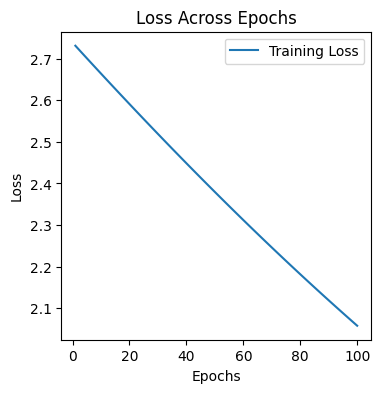

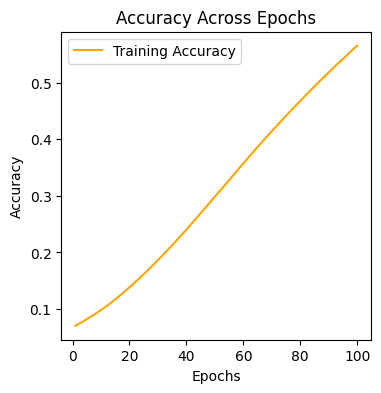

In [19]:
jfk_MLR_model, jfk_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_jfk, Y_train_torch_jfk, X_test_torch_jfk, Y_test_torch_jfk)


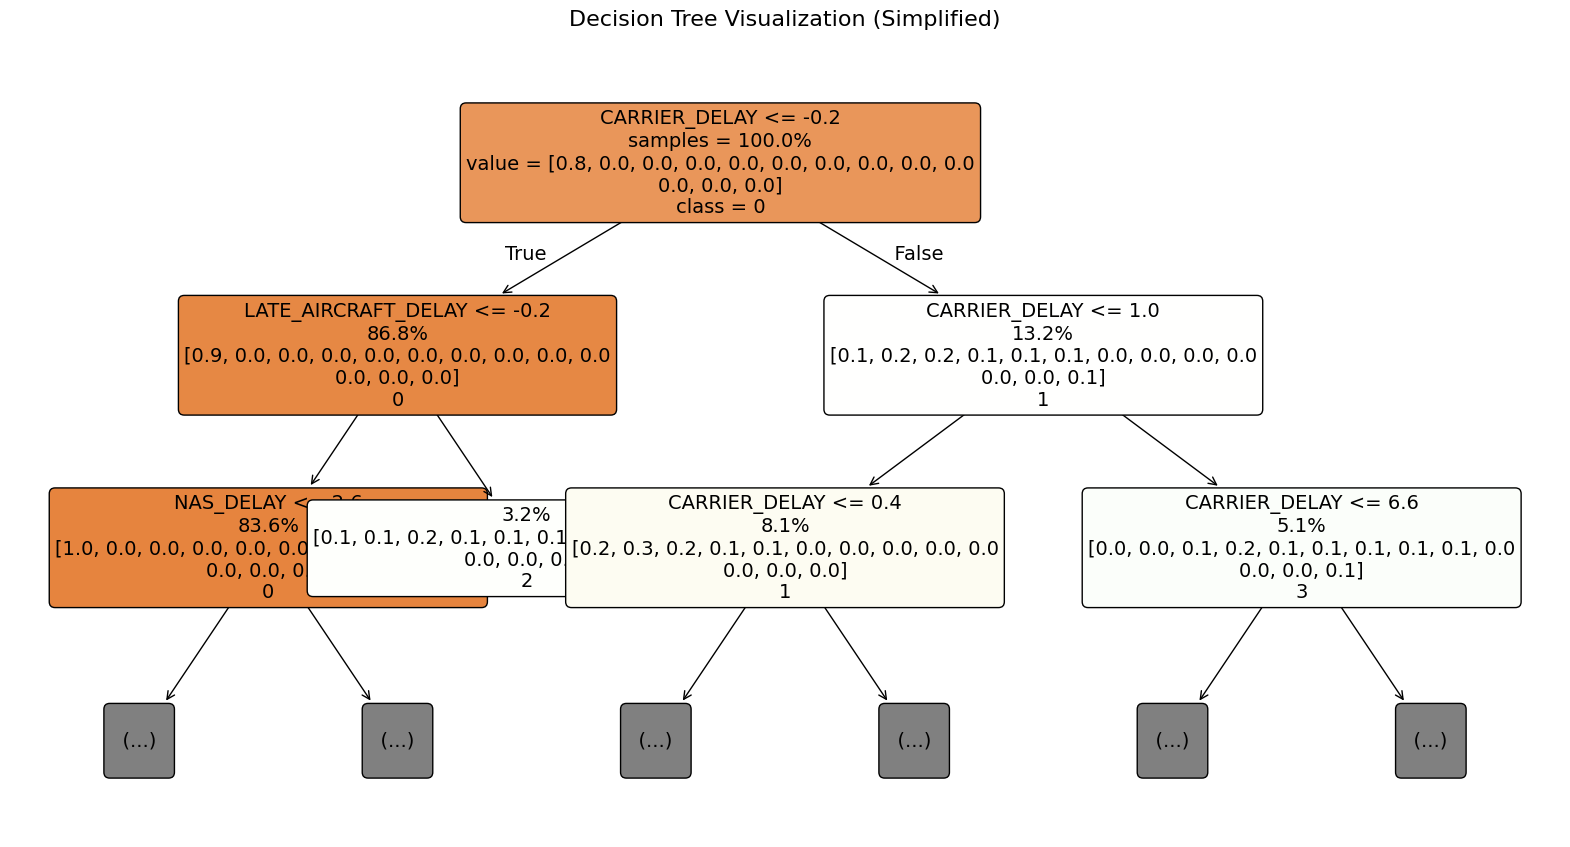

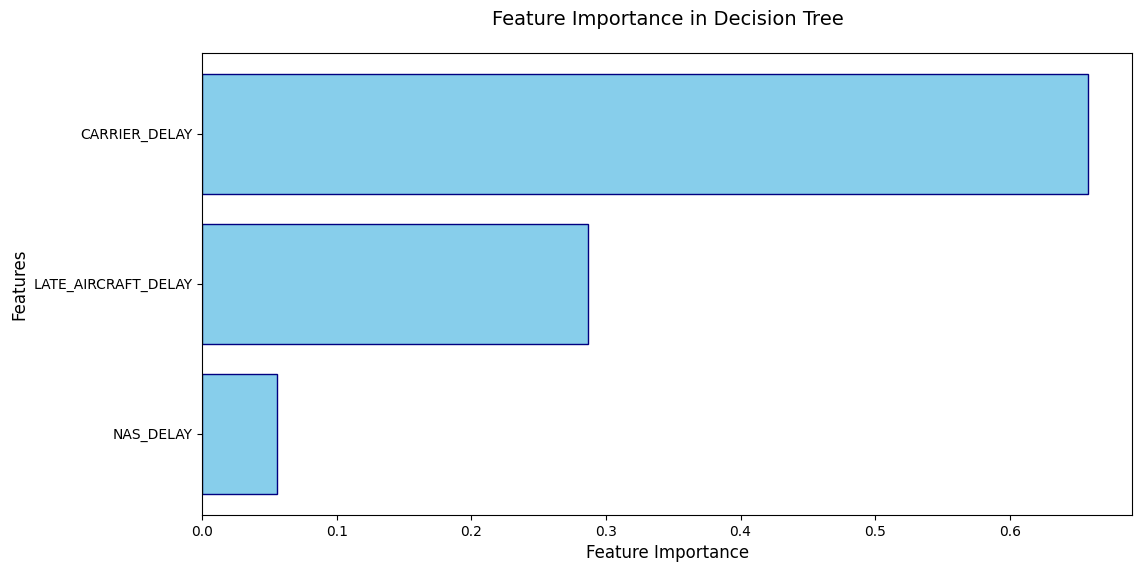


Training Set Metrics:
Accuracy: 0.8827
Precision: 0.8692
Recall: 0.8827
F1: 0.8731

Test Set Metrics:
Accuracy: 0.8685
Precision: 0.8542
Recall: 0.8685
F1: 0.8573


c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
jfk_DT_model, jfk_metrics_DT = train_decision_tree(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)


to do:
- run baseline models on other datasets
- finalise tables and graphs for baseline models